<a href="https://colab.research.google.com/github/clementsiegrist/Face_maskDetection/blob/main/mask_detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Abstract 


*Install and import relevant libraries and set color background and styles for nice visualization*

In [4]:
!pip install xmltodict #installing the library to read XMl files
import xmltodict

In [5]:
import numpy as np # linear algebra
import matplotlib.pyplot as plt
%matplotlib inline
import matplotlib.patches as patches
import os
from PIL import Image
import cv2
import warnings
warnings.filterwarnings("ignore")
import warnings
warnings.filterwarnings('ignore')
import seaborn as sns
from pylab import rcParams
import os
import cv2
import matplotlib.pyplot as plt
import xmltodict
import random
from os import listdir
from os.path import isfile, join
import torchvision 
import torch 
import torchvision.models as models
import torchvision.transforms as transforms
import torchvision.datasets as datasets
#import all modules
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import seaborn as sns
import random as rn
import tensorflow as tf
import cv2
import glob
from tqdm import tqdm
import xml.etree.ElementTree as ET
%matplotlib inline
%config InlineBackend.figure_format='retina'
plt.style.use(['seaborn-white'])

sns.set(style='whitegrid', palette='muted', font_scale=1.2)
HAPPY_COLORS_PALETTE = ["#01BEFE", "#FFDD00", "#FF7D00", "#FF006D", "#ADFF02", "#8F00FF"]
sns.set_palette(sns.color_palette(HAPPY_COLORS_PALETTE))
rcParams['figure.figsize'] = 12, 8

# **I. Exploratory Data Analysis**

Mount the drive, parse the xml files in order to get the annotations and convert the obtained datas to a panda dataframe for better visualization

In [6]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)
# https://www.kaggle.com/prekshabhavsar/face-mask-detection-with-92-accuracy
data_folder = '/content/drive/MyDrive/Data' #Change this path!!
root_folder = '/content/drive/MyDrive'
path_im = '/content/drive/MyDrive/Data/images/'
images_path = '/content/drive/MyDrive/Data/images'
print("Image path = {}".format(images_path))
print("Total number of images : {}".format(len(os.listdir(images_path))))
Annotation_path = '/content/drive/MyDrive/Data/annotations'
print("Annotation path = {}".format(Annotation_path))
print("Total Annotation files are {}".format(len(os.listdir(Annotation_path))))
path_an = '/content/drive/MyDrive/Data/annotations/'
PATH = '/content/drive/MyDrive/Data'
os.listdir(PATH)
ANNOTATIONS_PATH = os.path.join(PATH, "annotations")
IMAGE_PATH = os.path.join(PATH, "images")

data = []
sorted_annot_list = sorted(os.listdir(ANNOTATIONS_PATH), key=lambda x: int(x.split('.')[0][12:]))

for f_name in tqdm(sorted_annot_list):
    with open(os.path.join(ANNOTATIONS_PATH, f_name), 'r') as file:
        annot = xmltodict.parse(file.read())['annotation']
        if type(annot['object']) != list:
            annot['object'] = [annot['object']]
        data.append(annot)

data_df = pd.json_normalize(data)

  0%|          | 0/853 [00:00<?, ?it/s]

Mounted at /content/drive
Image path = /content/drive/MyDrive/Data/images
Total number of images : 853
Annotation path = /content/drive/MyDrive/Data/annotations
Total Annotation files are 853


100%|██████████| 853/853 [00:01<00:00, 813.62it/s]


In [ ]:
data_df

folder             filename segmented  ... size.width size.height size.depth
0    images    maksssksksss0.png         0  ...        512         366          3
1    images    maksssksksss1.png         0  ...        400         156          3
2    images    maksssksksss2.png         0  ...        400         290          3
3    images    maksssksksss3.png         0  ...        400         271          3
4    images    maksssksksss4.png         0  ...        301         400          3
..      ...                  ...       ...  ...        ...         ...        ...
848  images  maksssksksss848.png         0  ...        400         268          3
849  images  maksssksksss849.png         0  ...        400         236          3
850  images  maksssksksss850.png         0  ...        400         200          3
851  images  maksssksksss851.png         0  ...        301         400          3
852  images  maksssksksss852.png         0  ...        267         400          3

[853 rows x 7 columns]

In this section,  we vizualize the histogram ranking the images by the number of objects detected for each images

In data_df, for each row of the 'object' column you have a certain number of list, each list corresponding to one detection. So if you have to detections, we have two list which gives us the number of instances per images

In [8]:
data_df['num_of_object'] = data_df.object.map(len)
data_df['num_of_object']

0      3
1      9
2      4
3      9
4      1
      ..
848    4
849    4
850    3
851    1
852    2
Name: num_of_object, Length: 853, dtype: int64

Now let is plot the histogram of the the distribution of the number of instances per image

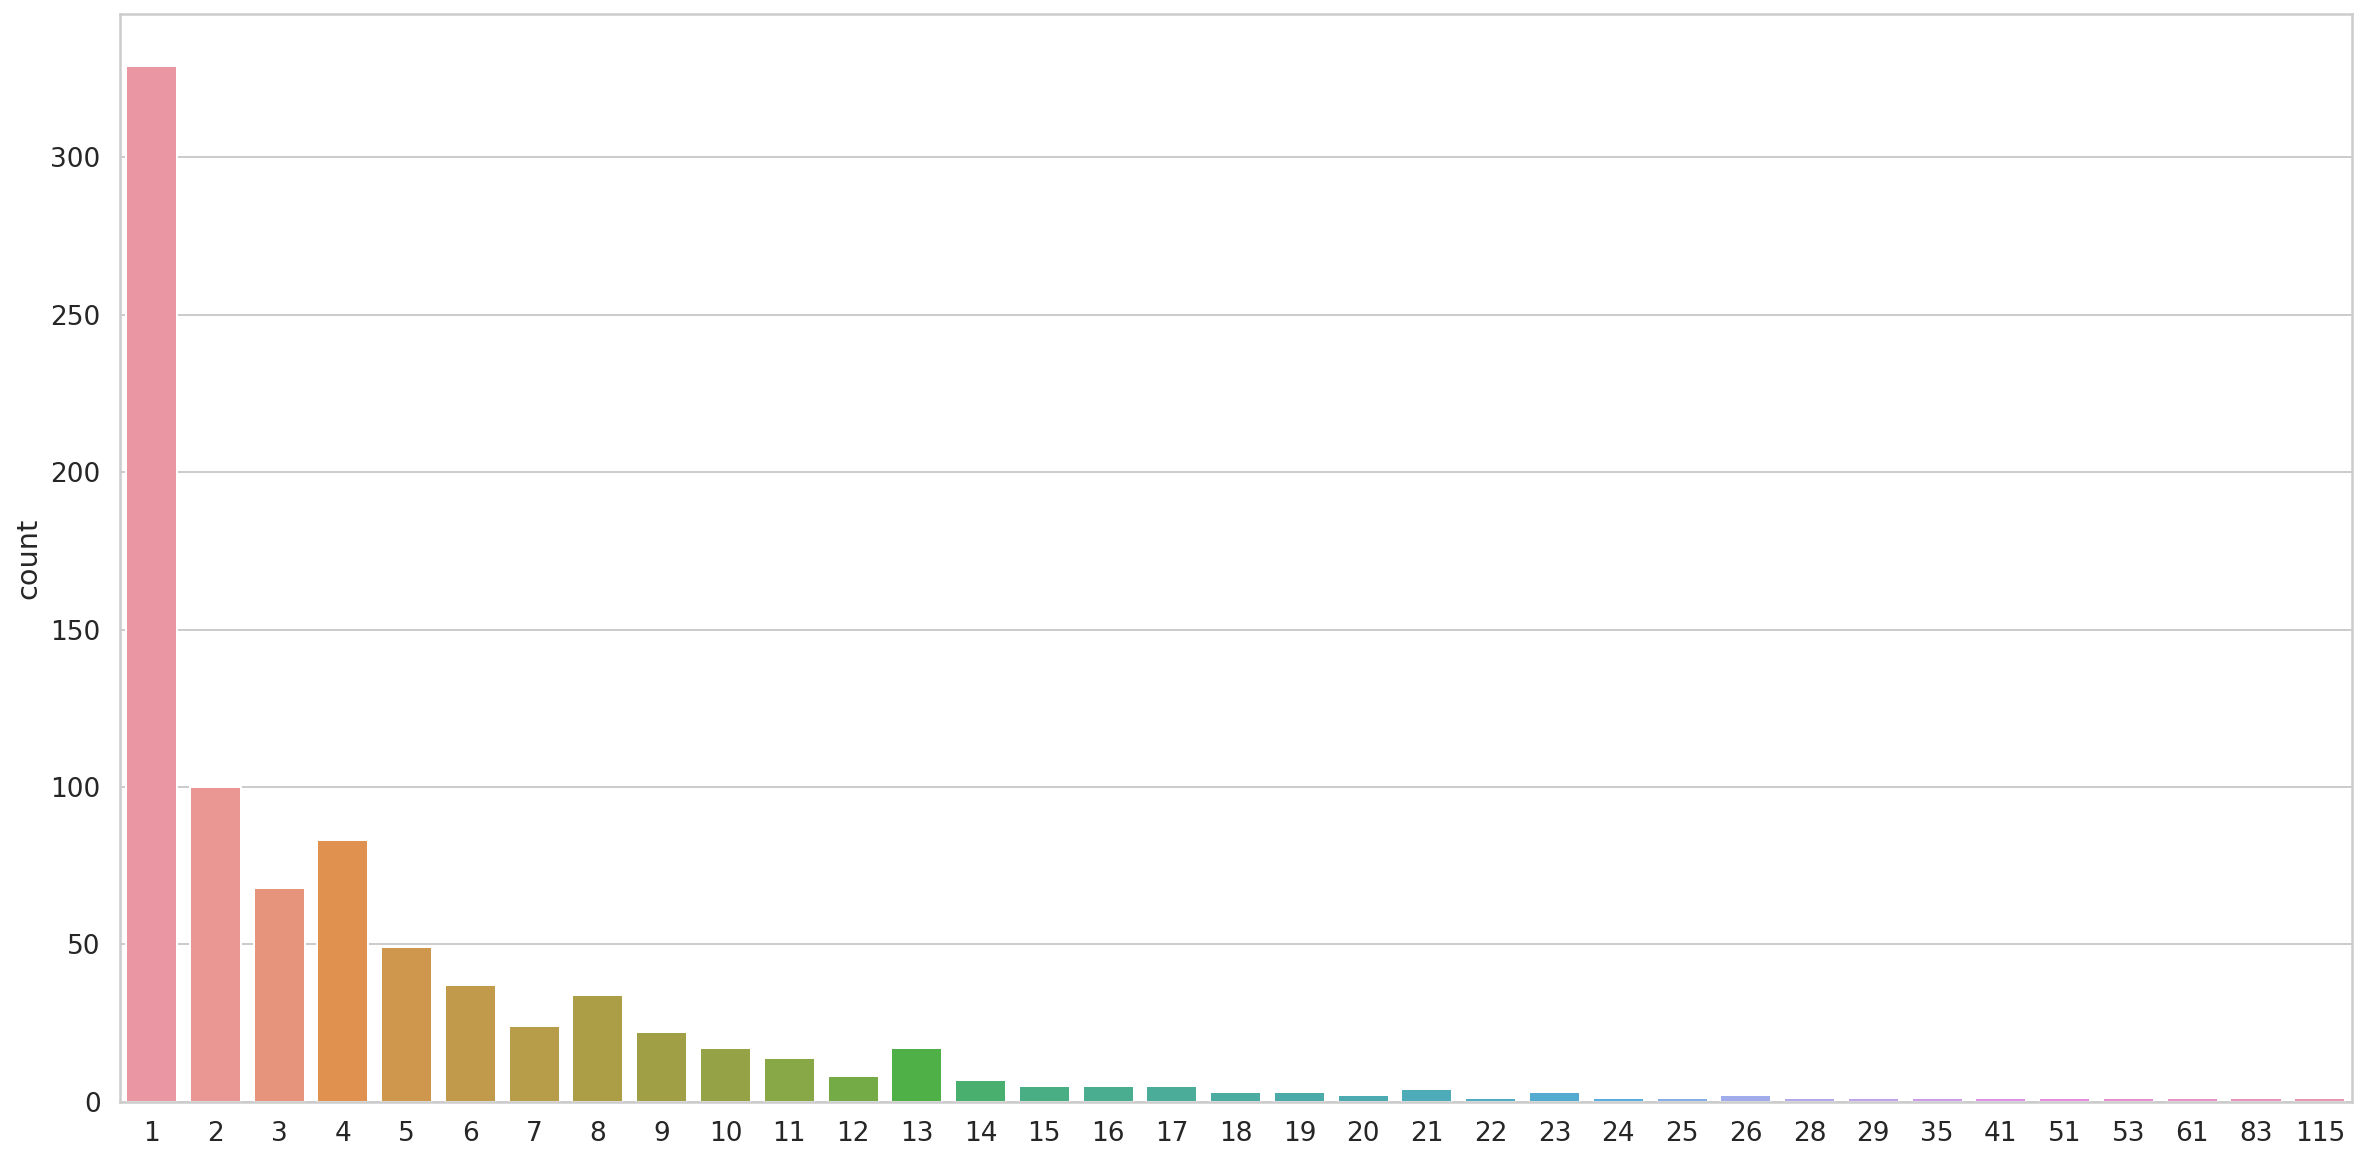

In [9]:
plt.figure(figsize=(20, 10))
sns.countplot(data_df.num_of_object.values)
plt.show()

We can see that in roughly 75% of images they are between 1 and 4 instances detected (mask badly wore, no mask or masked people). So it is possibly a first bias of the dataset though we can not draw conclusion for these informations at this stage.


Now let is created an other dataframe in order to visualize more clearly what we have
in the 'object column' which is the column we are interested in.

Now we want to know approximatively what is the number of instances per class.
What we do in first instance is to keep only the rows in which the number of instances
that should be detected is inferior to 15.

In [10]:
data_df[data_df.num_of_object <= 15].num_of_object.sum()
data_df = data_df[data_df.num_of_object <= 15]
data_df

folder             filename  ... size.depth num_of_object
0    images    maksssksksss0.png  ...          3             3
1    images    maksssksksss1.png  ...          3             9
2    images    maksssksksss2.png  ...          3             4
3    images    maksssksksss3.png  ...          3             9
4    images    maksssksksss4.png  ...          3             1
..      ...                  ...  ...        ...           ...
848  images  maksssksksss848.png  ...          3             4
849  images  maksssksksss849.png  ...          3             4
850  images  maksssksksss850.png  ...          3             3
851  images  maksssksksss851.png  ...          3             1
852  images  maksssksksss852.png  ...          3             2

[814 rows x 8 columns]

What we do here, is to create a dataframe with the exact same columns as the precendent
but with more rows, each row corresponding to one individual bounding. 
Here np.repeat the elements of an array according to the number given in the second argument. In this case, this case we give as a second argument the 'num_of_objects' columns which for each row as the corresponding number we want in order for the repetition to correspond to correspond to the number of bounding boxes per image.

In [11]:
from itertools import chain

num_object_per_images = data_df.num_of_object
print('Num of object is  :', print(num_object_per_images))

image_data = pd.DataFrame({
    'filename': np.repeat(data_df['filename'], num_object_per_images), 
    'segmented': np.repeat(data_df['segmented'], num_object_per_images), 
    'object': chain.from_iterable(data_df['object'].values), 
    'width': np.repeat(data_df['size.width'], num_object_per_images),
    'height': np.repeat(data_df['size.height'], num_object_per_images),
    'depth': np.repeat(data_df['size.depth'], num_object_per_images)
})

image_data.reset_index(inplace=True, drop=True)
objects = pd.DataFrame(image_data.object.map(dict).tolist())
data = pd.concat([image_data, objects], axis=1)
data.drop(columns='object', inplace=True)


0      3
1      9
2      4
3      9
4      1
      ..
848    4
849    4
850    3
851    1
852    2
Name: num_of_object, Length: 814, dtype: int64
Num of object is  : None


In [ ]:
data

filename  ...                                             bndbox
0       maksssksksss0.png  ...  {'xmin': '79', 'ymin': '105', 'xmax': '109', '...
1       maksssksksss0.png  ...  {'xmin': '185', 'ymin': '100', 'xmax': '226', ...
2       maksssksksss0.png  ...  {'xmin': '325', 'ymin': '90', 'xmax': '360', '...
3       maksssksksss1.png  ...  {'xmin': '321', 'ymin': '34', 'xmax': '354', '...
4       maksssksksss1.png  ...  {'xmin': '224', 'ymin': '38', 'xmax': '261', '...
...                   ...  ...                                                ...
2979  maksssksksss850.png  ...  {'xmin': '146', 'ymin': '30', 'xmax': '176', '...
2980  maksssksksss850.png  ...  {'xmin': '323', 'ymin': '47', 'xmax': '351', '...
2981  maksssksksss851.png  ...  {'xmin': '66', 'ymin': '205', 'xmax': '156', '...
2982  maksssksksss852.png  ...  {'xmin': '139', 'ymin': '94', 'xmax': '198', '...
2983  maksssksksss852.png  ...  {'xmin': '92', 'ymin': '86', 'xmax': '132', 'y...

[2984 rows x 11 columns]

We drop useless column so that we have more visibility on our novel dataframe

In [12]:
data.drop(columns=['segmented','depth','truncated','occluded','difficult', 'pose'], inplace=True)
data

filename  ...                                             bndbox
0       maksssksksss0.png  ...  {'xmin': '79', 'ymin': '105', 'xmax': '109', '...
1       maksssksksss0.png  ...  {'xmin': '185', 'ymin': '100', 'xmax': '226', ...
2       maksssksksss0.png  ...  {'xmin': '325', 'ymin': '90', 'xmax': '360', '...
3       maksssksksss1.png  ...  {'xmin': '321', 'ymin': '34', 'xmax': '354', '...
4       maksssksksss1.png  ...  {'xmin': '224', 'ymin': '38', 'xmax': '261', '...
...                   ...  ...                                                ...
2979  maksssksksss850.png  ...  {'xmin': '146', 'ymin': '30', 'xmax': '176', '...
2980  maksssksksss850.png  ...  {'xmin': '323', 'ymin': '47', 'xmax': '351', '...
2981  maksssksksss851.png  ...  {'xmin': '66', 'ymin': '205', 'xmax': '156', '...
2982  maksssksksss852.png  ...  {'xmin': '139', 'ymin': '94', 'xmax': '198', '...
2983  maksssksksss852.png  ...  {'xmin': '92', 'ymin': '86', 'xmax': '132', 'y...

[2984 rows x 5 columns]

Now we count the values of the 'name' column

In [13]:
data['name'].value_counts()

with_mask                2365
without_mask              515
mask_weared_incorrect     104
Name: name, dtype: int64

In [14]:
data['name'].unique()

array(['without_mask', 'with_mask', 'mask_weared_incorrect'], dtype=object)

Plot the histogram of the number of instances per class for better visualization

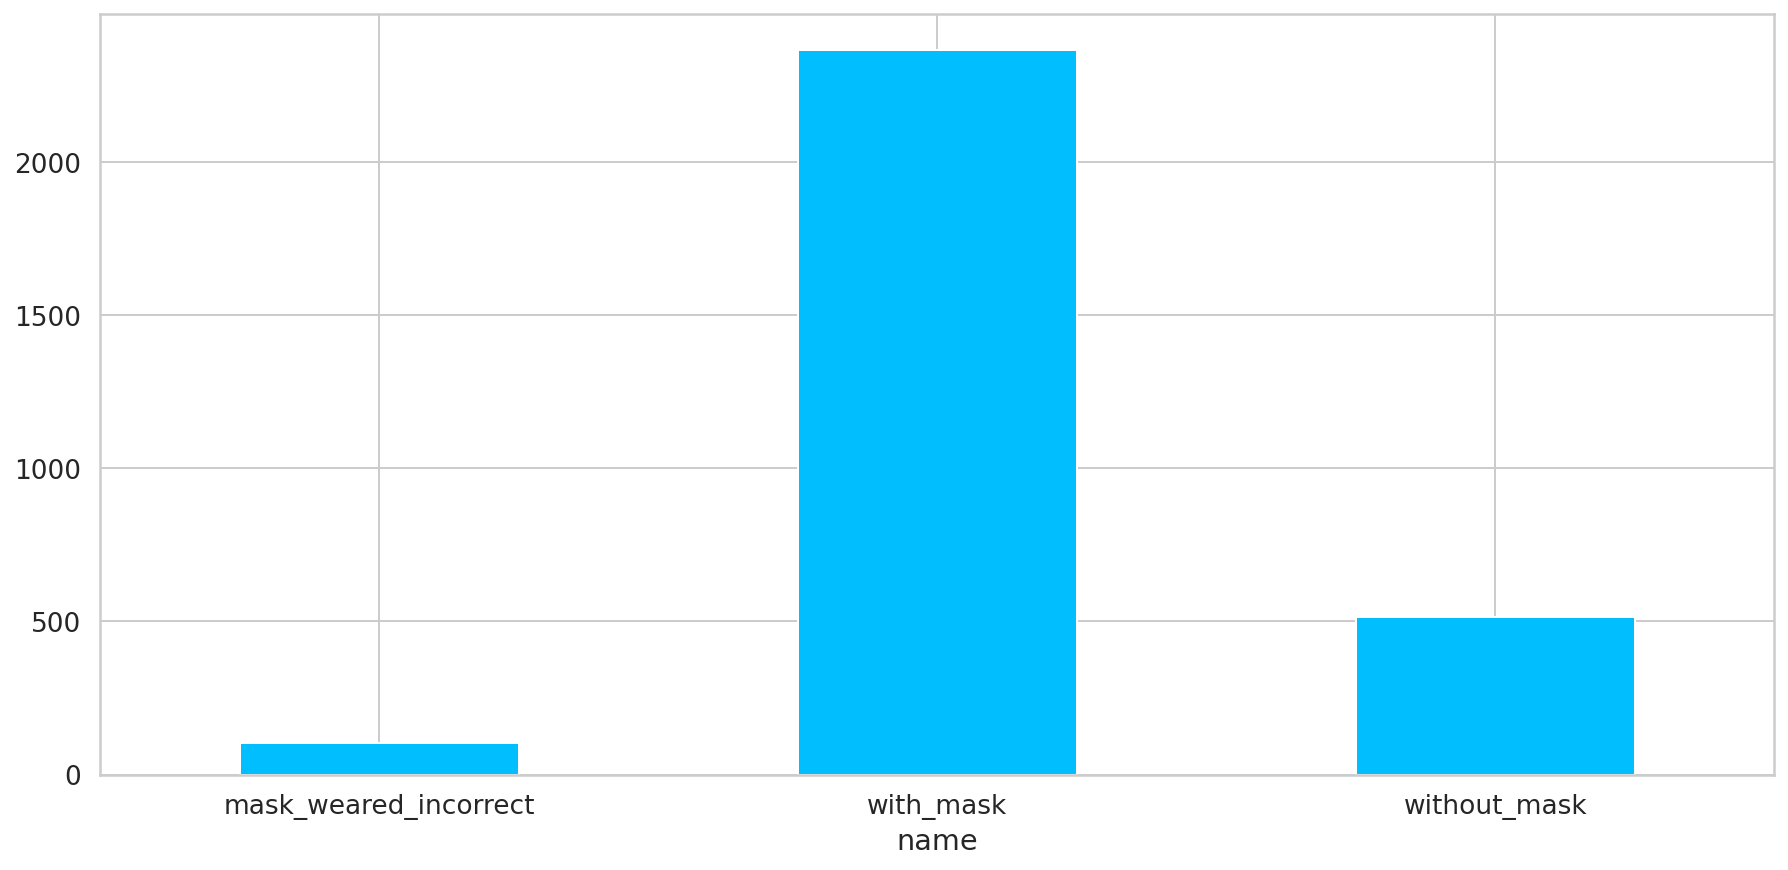

In [15]:
data.groupby('name')['filename'].count().plot.bar(figsize=(15,7), rot=0, grid=True)

# **II. Loading and preparing the Dataset**

# *II. A. Dataset Preparation and sample visualization*

We iterate over our /Data directory and store the imagenames and xmlnames. 
Then we reiterate over the previously created list and open 

In [7]:
# Read parse and store the images

imagenames=[] # list of imagefile names
xmlnames=[] # list of xmlfile names

for dirname, _, filenames in os.walk('/content/drive/MyDrive/Data'):
    for filename in filenames:
        
        if os.path.join(dirname, filename)[-3:]!="xml":
            imagenames.append(filename)
        else:
            xmlnames.append(filename)

listing=[]

for i in imagenames[:]:
    with open(path_an+i[:-4]+".xml") as fd:
        doc=xmltodict.parse(fd.read())
    temp=doc["annotation"]["object"]
    
    if type(temp)==list:
        for i in range(len(temp)):
            listing.append(temp[i]["name"])
    else:
        listing.append(temp["name"])

for i in set(listing):
    print(i)

print('length listing', len(listing))
print(listing)
from collections import Counter

a = dict(Counter(listing))
print(a)
index = np.arange(0, len(listing))
df = pd.Series(listing)
df = df.str.get_dummies()

without_mask
mask_weared_incorrect
with_mask
length listing 4072
['with_mask', 'with_mask', 'with_mask', 'with_mask', 'with_mask', 'with_mask', 'with_mask', 'with_mask', 'without_mask', 'without_mask', 'with_mask', 'without_mask', 'with_mask', 'with_mask', 'without_mask', 'without_mask', 'without_mask', 'with_mask', 'with_mask', 'without_mask', 'without_mask', 'without_mask', 'with_mask', 'with_mask', 'without_mask', 'with_mask', 'without_mask', 'with_mask', 'without_mask', 'without_mask', 'without_mask', 'without_mask', 'with_mask', 'with_mask', 'without_mask', 'without_mask', 'without_mask', 'without_mask', 'with_mask', 'without_mask', 'without_mask', 'without_mask', 'without_mask', 'with_mask', 'with_mask', 'without_mask', 'without_mask', 'without_mask', 'without_mask', 'with_mask', 'without_mask', 'with_mask', 'with_mask', 'without_mask', 'without_mask', 'with_mask', 'with_mask', 'with_mask', 'with_mask', 'with_mask', 'without_mask', 'without_mask', 'with_mask', 'mask_weared_incorr

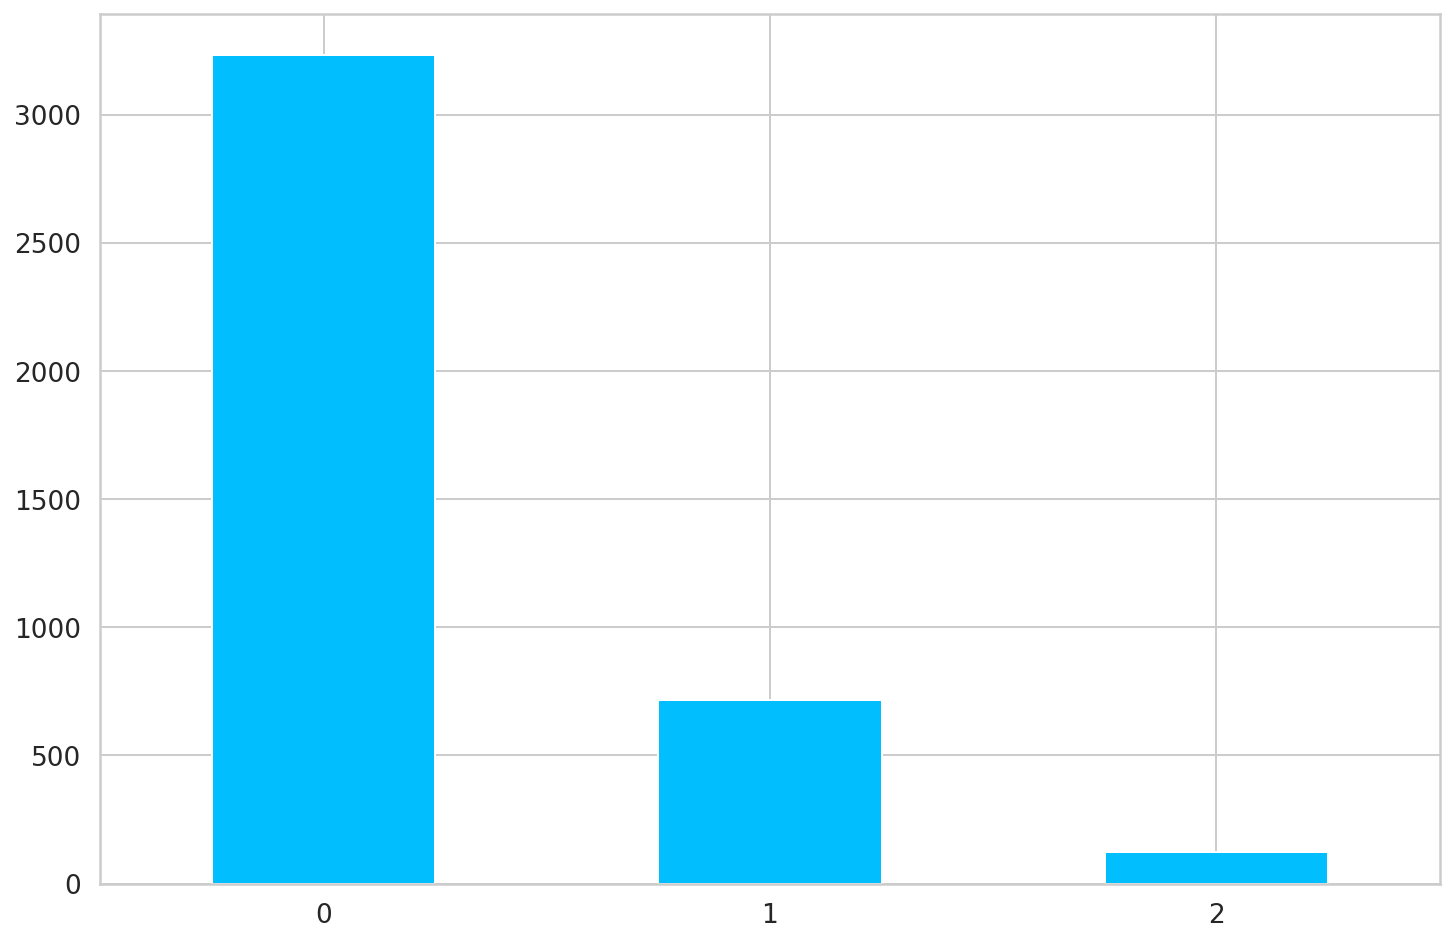

In [17]:
df.index
data_count = df.value_counts().plot.bar(rot=0, xticks=(0, 1, 2), xlabel=('good, badly, no mask wore'), use_index=False)

0 = with_mask

1 =  mask_weared_incorrect

2 = without_mask

This time we plotted the histogram of the number of instances per class but for every instances and found roughly the same proportion than in the previous histogram that was plot based on a filter. 





Now we visualize a sample of the dataset

In [8]:
# mapping for predictions and analysis purpose
options={"with_mask":0,"without_mask":1,"mask_weared_incorrect":2} 

# function to visualize images
def draw_bounding_box(input_image):

    with open(path_an+input_image[:-4]+".xml") as fd:
        doc=xmltodict.parse(fd.read())
    image=plt.imread(os.path.join(path_im+input_image))
    fig,ax=plt.subplots(1)
    ax.axis("off")
    fig.set_size_inches(10,5)
    temp=doc["annotation"]["object"]

    if type(temp)==list:
        for i in range(len(temp)):

            if temp[i]["name"]=="with_mask":
                a,b,c,d=list(map(int,temp[i]["bndbox"].values()))
                patch=patches.Rectangle((a,b),c-a,d-b,linewidth=1, edgecolor='g',facecolor="none",)
                ax.add_patch(patch)

            if temp[i]["name"]=="without_mask":
                a,b,c,d=list(map(int,temp[i]["bndbox"].values()))     
                patch=patches.Rectangle((a,b),c-a,d-b,linewidth=1, edgecolor='r',facecolor="none",)
                ax.add_patch(patch)
                
            if temp[i]["name"]=="mask_weared_incorrect":
                a,b,c,d=list(map(int,temp[i]["bndbox"].values()))
                patch=patches.Rectangle((a,b),c-a,d-b,linewidth=1, edgecolor='y',facecolor="none",)
                ax.add_patch(patch)
    else:
        a,b,c,d=list(map(int,temp["bndbox"].values()))
        edgecolor={"with_mask":"g","without_mask":"g","mask_weared_incorrect":"y"}
        patch=patches.Rectangle((a,b),d-b,c-a,linewidth=1, edgecolor=edgecolor[temp["name"]],facecolor="none",)
    ax.imshow(image)
    ax.add_patch(patch)

Use the previous function in order to plot 10 images

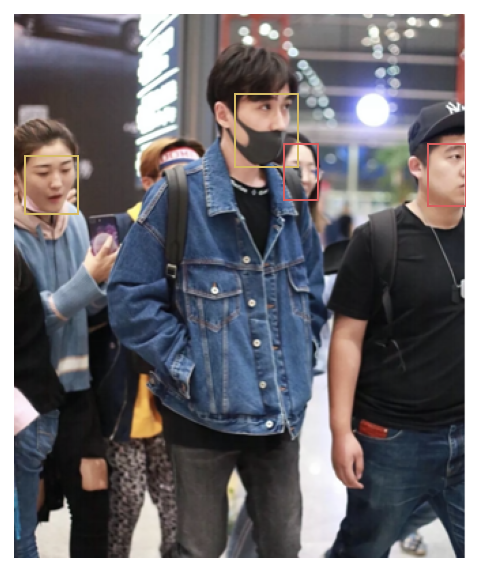

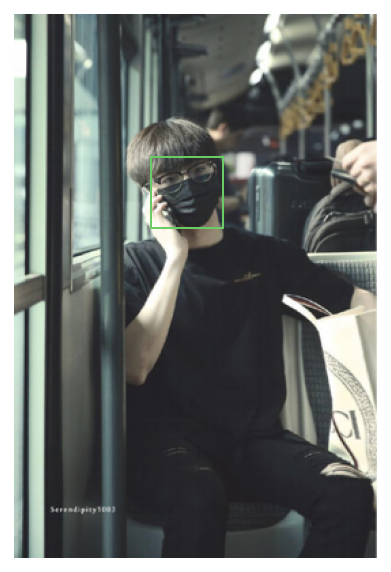

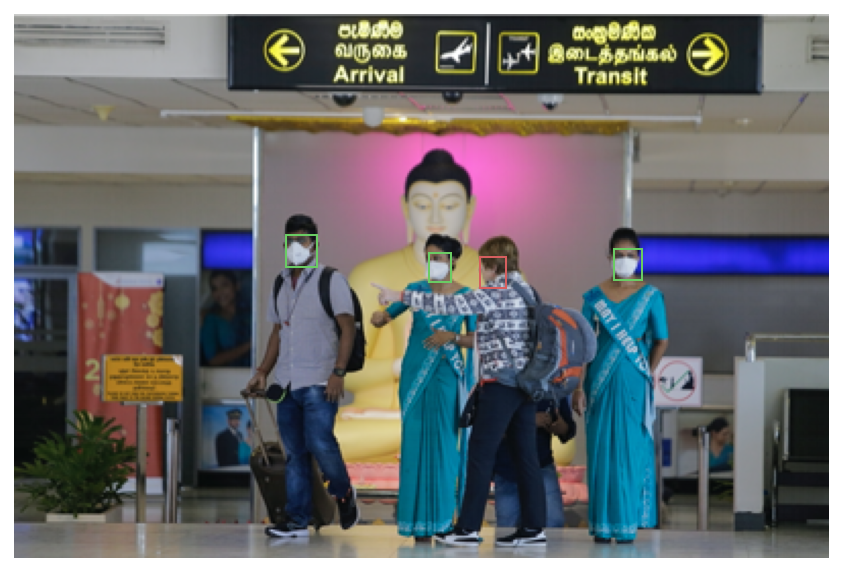

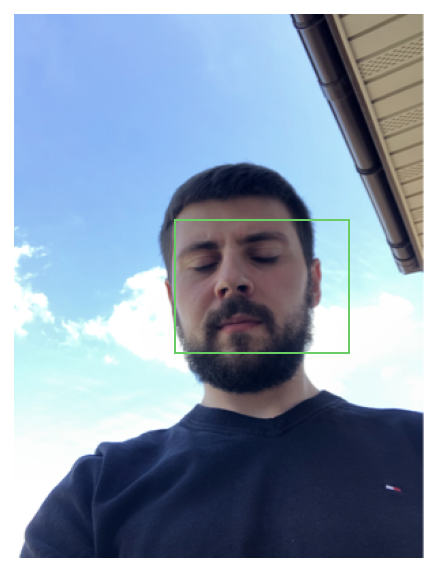

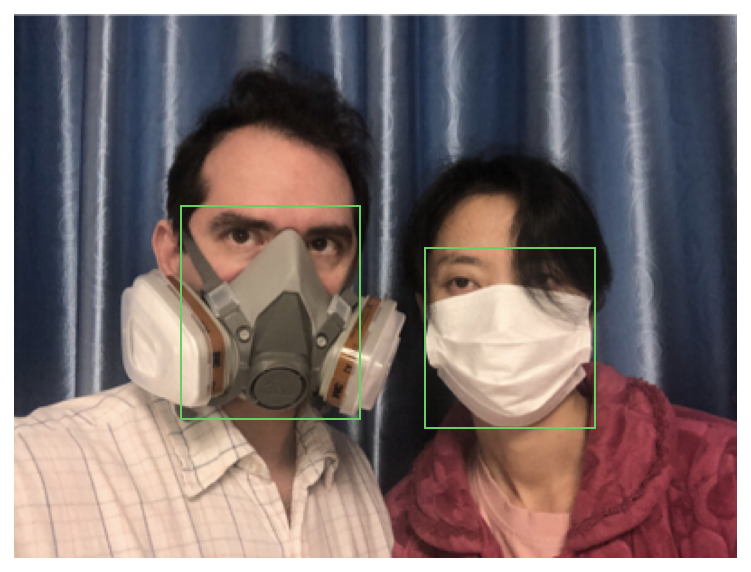

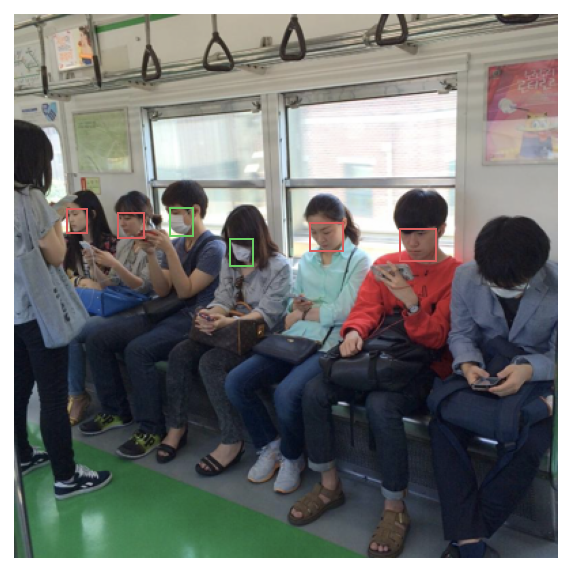

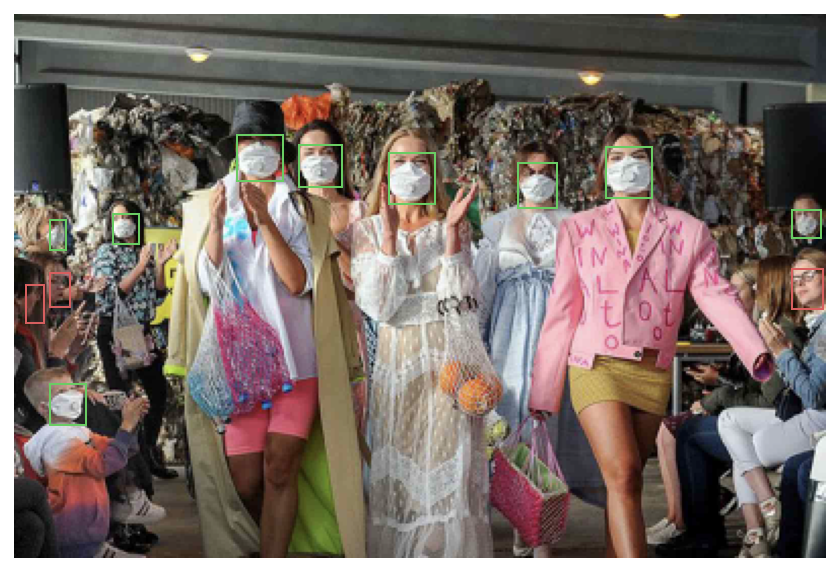

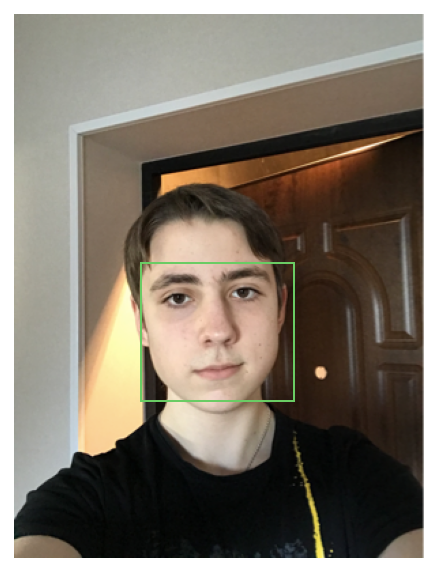

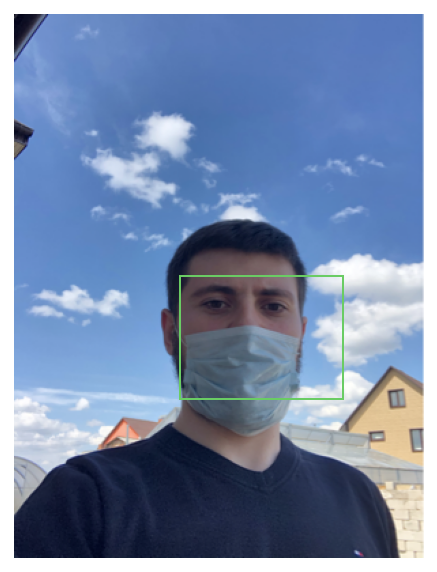

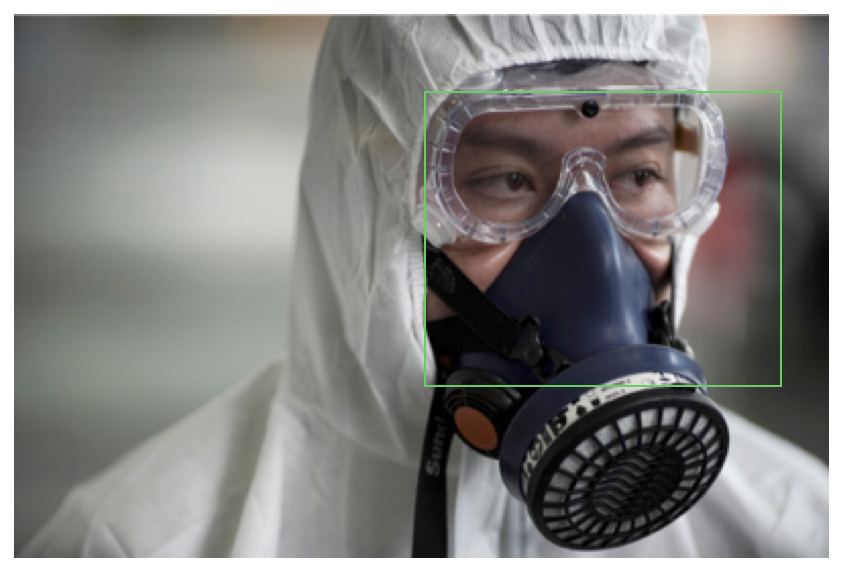

In [19]:
for i in range(15,25):
    draw_bounding_box(imagenames[i])

Create the image dataset and the labels and convert them to pytorch tensors.

In [9]:
def make_dataset(no_of_images): # function to make dataset
    
    image_tensor=[]
    label_tensor=[]
    
    for i,j in enumerate(no_of_images):

        with open(path_an+j[:-4]+".xml") as fd:
            doc = xmltodict.parse(fd.read())

        if type(doc["annotation"]["object"])!=list:
            temp = doc["annotation"]["object"]
            a,b,c,d = list(map(int,temp["bndbox"].values()))
            label = options[temp["name"]]
            image = transforms.functional.crop(Image.open(path_im+j).convert("RGB"), b,a,d-b,c-a)
            image_tensor.append(my_transform(image))
            label_tensor.append(torch.tensor(label))
        
        else:
            temp = doc["annotation"]["object"]
            for k in range(len(temp)):
                a,b,c,d=list(map(int,temp[k]["bndbox"].values()))
                label=options[temp[k]["name"]]
                image=transforms.functional.crop(Image.open(path_im+j).convert("RGB"), b,a,d-b,c-a)
                image_tensor.append(my_transform(image))
                label_tensor.append(torch.tensor(label))
                
    final_dataset=[[k,l] for k,l in zip(image_tensor,label_tensor)]
    return tuple(final_dataset)


Use the pytorch dataloarders that we be used later in order to process datas by batch in order to avoid memory overflow.



In [10]:
# importing neccessary libraries for deeplearning task..
import torch
from torchvision import datasets,transforms,models
from torch.utils.data import Dataset,DataLoader

my_transform=transforms.Compose([transforms.Resize((226,226)),
                                 transforms.ToTensor()])

# making a dataset
dataset = make_dataset(imagenames) 
train_size = int(len(dataset)*0.8)
test_size = len(dataset)-train_size

# Split the dataset between train and testing set
batch_size = 32
trainset,testset = torch.utils.data.random_split(dataset,[train_size,test_size])

# Load data with Pytorch DataLoader
train_loader = DataLoader(dataset=trainset,batch_size=batch_size,shuffle=True)
test_loader = DataLoader(dataset=testset,batch_size=batch_size,shuffle=True)

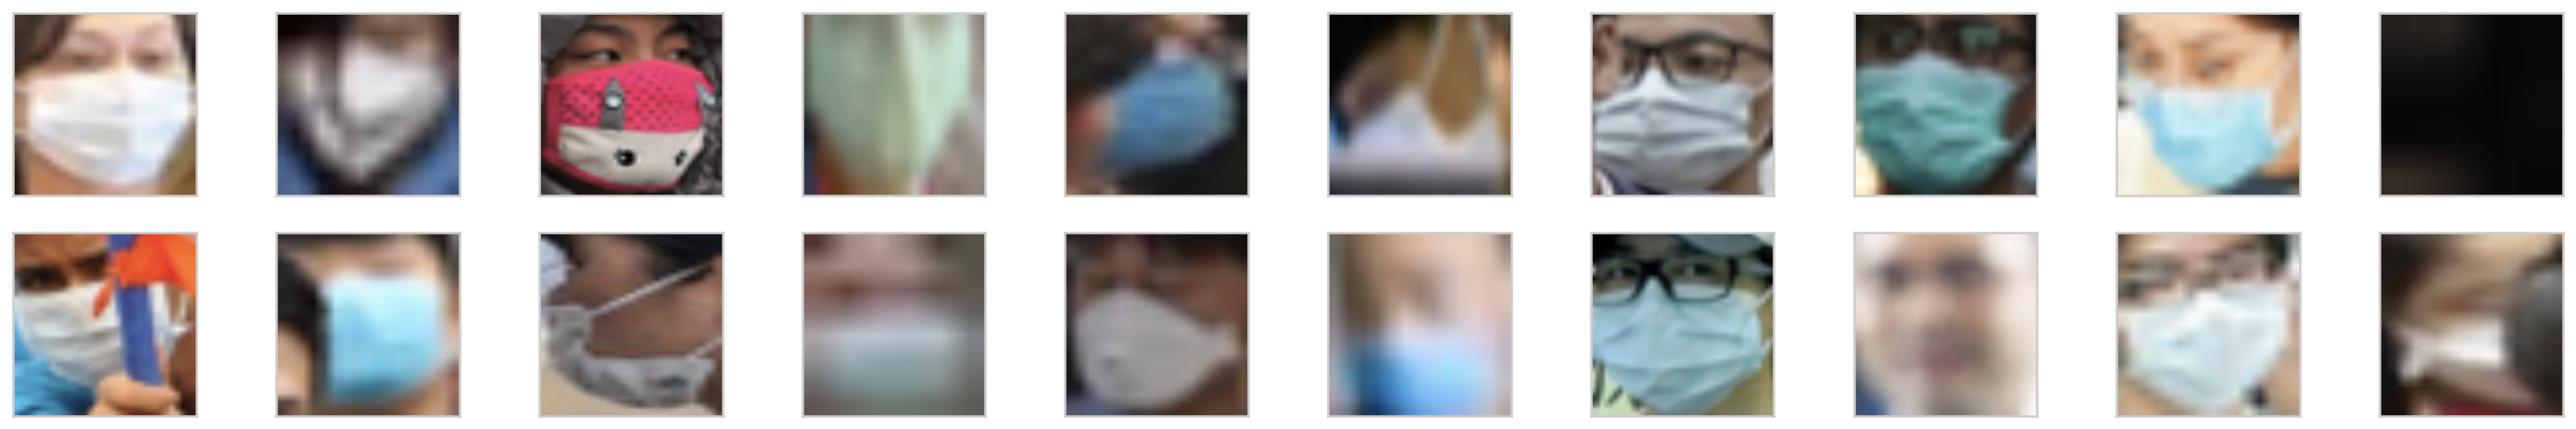

In [11]:
dataiter = iter(train_loader) 
images , labels = dataiter.next()
images = images.numpy()

fig = plt.figure(figsize=(25,4))
for idx in np.arange(20):
    ax = fig.add_subplot(2,20/2,idx+1,xticks=[],yticks=[])
    plt.imshow(np.transpose(images[idx],(1,2,0)))

# *II. B. Model creation and training*

Download a library named geopt which include recently developped optimizers, more informations about the one used in this work is provided in our descriptive pdf.

In [12]:
!pip install geoopt

Import necessary pytorch libraries, set the seed, instantiate the model, the loss, the optimizer and fill the resnet.parameters to them.

In [21]:
import torch.nn as nn
import torch.optim as optim
import geoopt

# Important : set the seed for reproductibility 
RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)

# We Will use pretrained resnet34 layer model.
resnet = models.resnet50(pretrained=True)
for param in resnet.parameters():
    param.requires_grad=False

# 
n_inputs = resnet.fc.in_features
last_layer = nn.Linear(n_inputs,3)
resnet.fc.out_features = last_layer

if torch.cuda.is_available():
    resnet.cuda()
    
print(resnet.fc.out_features)

if torch.cuda.is_available(): #checking for GPU availability
    device = torch.device("cuda")
    print('There are %d GPU(s) available.' % torch.cuda.device_count())
    print('We will use the GPU:', torch.cuda.get_device_name(0))

else:
    print('No GPU available, using the CPU instead.')
    device = torch.device("cpu")

for paramet in resnet.parameters():
    paramet.requires_grad=True

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(resnet.parameters(),lr=0.001)
optim = geoopt.optim.RiemannianAdam(resnet.parameters(), lr=0.0001)

Downloading: "https://download.pytorch.org/models/resnet50-19c8e357.pth" to /root/.cache/torch/hub/checkpoints/resnet50-19c8e357.pth



Linear(in_features=2048, out_features=3, bias=True)
There are 1 GPU(s) available.
We will use the GPU: Tesla T4


Choose a number of epochs, iterate over it, then iterates over the dataloader for training. Basic metrics are stored and displayed during training.
Repeat the same process for testing but without training (no optim.zero_grad(), loss.backward() and optim.step(). 

In [22]:
n_epochs=40

for epoch in range(1,n_epochs+1):

    train_loss = 0.0
    acc_train = 0.0
    predictions = []
    real_values = []
    print('########################  TRAIN THE MODEL  ########################')
    for batch,(data,target) in enumerate(train_loader):
    
    
        if torch.cuda.is_available():
            data , target = data.cuda(), target.cuda()
    
        optim.zero_grad()
        output=resnet(data)
        loss=criterion(output,target)
        loss.backward()
        optim.step()
        train_loss += loss.item()

        if batch%20==19:
            print("Epoch {}, batch {}, training loss {}".format(epoch, batch+1,train_loss/20))
        train_loss = 0.0

        _, pred_ = torch.max(output,1)
        predicted = pred_.numpy()[:,np.newaxis] if not torch.cuda.is_available() else pred_.cpu().numpy()[:,np.newaxis]
        actual_ = target.numpy()[:,np.newaxis] if not torch.cuda.is_available() else target.cpu().numpy()[:,np.newaxis]
        acc_train += np.sum(predicted== actual_)/len(target.cpu().numpy())
        #predictions.extend(predicted_)
        #real_values.extend(actual_)

Average_loss_ = train_loss/len(train_loader)
Average_acc_ = acc_train/len(train_loader)

print("Avg total loss is {:.6f}".format(Average_loss_))
print("Avg accuracy is {:.6f}".format(Average_acc_))

print('#########  Testing  ##########')
test_loss=0.0
acc=0
predictions_ = []
real_values_ = []
resnet.eval()

for data,target in test_loader:

    if torch.cuda.is_available():
        data,target=data.cuda(),target.cuda()
    output = resnet(data)
    loss = criterion(output,target)
    test_loss += loss.item()
    _, pred = torch.max(output,1)
    predicted = pred.numpy()[:,np.newaxis] if not torch.cuda.is_available() else pred.cpu().numpy()[:,np.newaxis]
    actual = target.numpy()[:,np.newaxis] if not torch.cuda.is_available() else target.cpu().numpy()[:,np.newaxis]
    acc += np.sum(predicted==actual)/len(target.cpu().numpy())
    predictions_.extend(pred)
    real_values_.extend(target)

Average_loss = test_loss/len(test_loader)
Average_acc = acc/len(test_loader)

print("Avg total loss is {:.6f}".format(Average_loss))
print("Avg accuracy is {:.6f}".format(Average_acc))

predictions = torch.stack(predictions_).cpu()
real_values = torch.stack(real_values_).cpu()



########################  TRAIN THE MODEL  ########################
Epoch 1, batch 20, training loss 0.011777488142251968
Epoch 1, batch 40, training loss 0.014782370626926422
Epoch 1, batch 60, training loss 0.0014828599989414216
Epoch 1, batch 80, training loss 0.011409367620944976
Epoch 1, batch 100, training loss 0.014258986711502076
########################  TRAIN THE MODEL  ########################
Epoch 2, batch 20, training loss 0.009007208794355393
Epoch 2, batch 40, training loss 0.0006958170793950558
Epoch 2, batch 60, training loss 0.00617155097424984
Epoch 2, batch 80, training loss 0.005056165158748627
Epoch 2, batch 100, training loss 0.00981004610657692
########################  TRAIN THE MODEL  ########################
Epoch 3, batch 20, training loss 0.0008499282412230968
Epoch 3, batch 40, training loss 0.0026023538783192636
Epoch 3, batch 60, training loss 0.006757999956607819
Epoch 3, batch 80, training loss 0.0007906041108071804
Epoch 3, batch 100, training loss 0

As you can see the average accuracy is almost perfect on the training set and excellent on the test set. We did not choose to split the data between train/test and validation as we wanted to keep as much data as possible for training in order to maximize the model performances. We can already see that the model "generalize well" at least on the dataset and with these two metrics ... Latter we will see that the model is not that good and far from being adapted to real life situations. 

A validation could be done on some parts of the massive dataset names MaskedFace-Net collected by French researchers [1] and available at the following adress : https://github.com/cabani/MaskedFace-Net

[1] Adnane Cabani, Karim Hammoudi, Halim Benhabiles, and Mahmoud Melkemi, "*MaskedFace-Net - A dataset of correctly/incorrectly masked face images in the context of COVID-19*", Smart Health, ISSN 2352-6483, Elsevier, 2020.

                       precision    recall  f1-score   support

            with_mask       0.99      0.99      0.99       647
mask_weared_incorrect       0.99      0.92      0.95       147
         without_mask       0.61      0.81      0.69        21

             accuracy                           0.97       815
            macro avg       0.86      0.91      0.88       815
         weighted avg       0.98      0.97      0.97       815



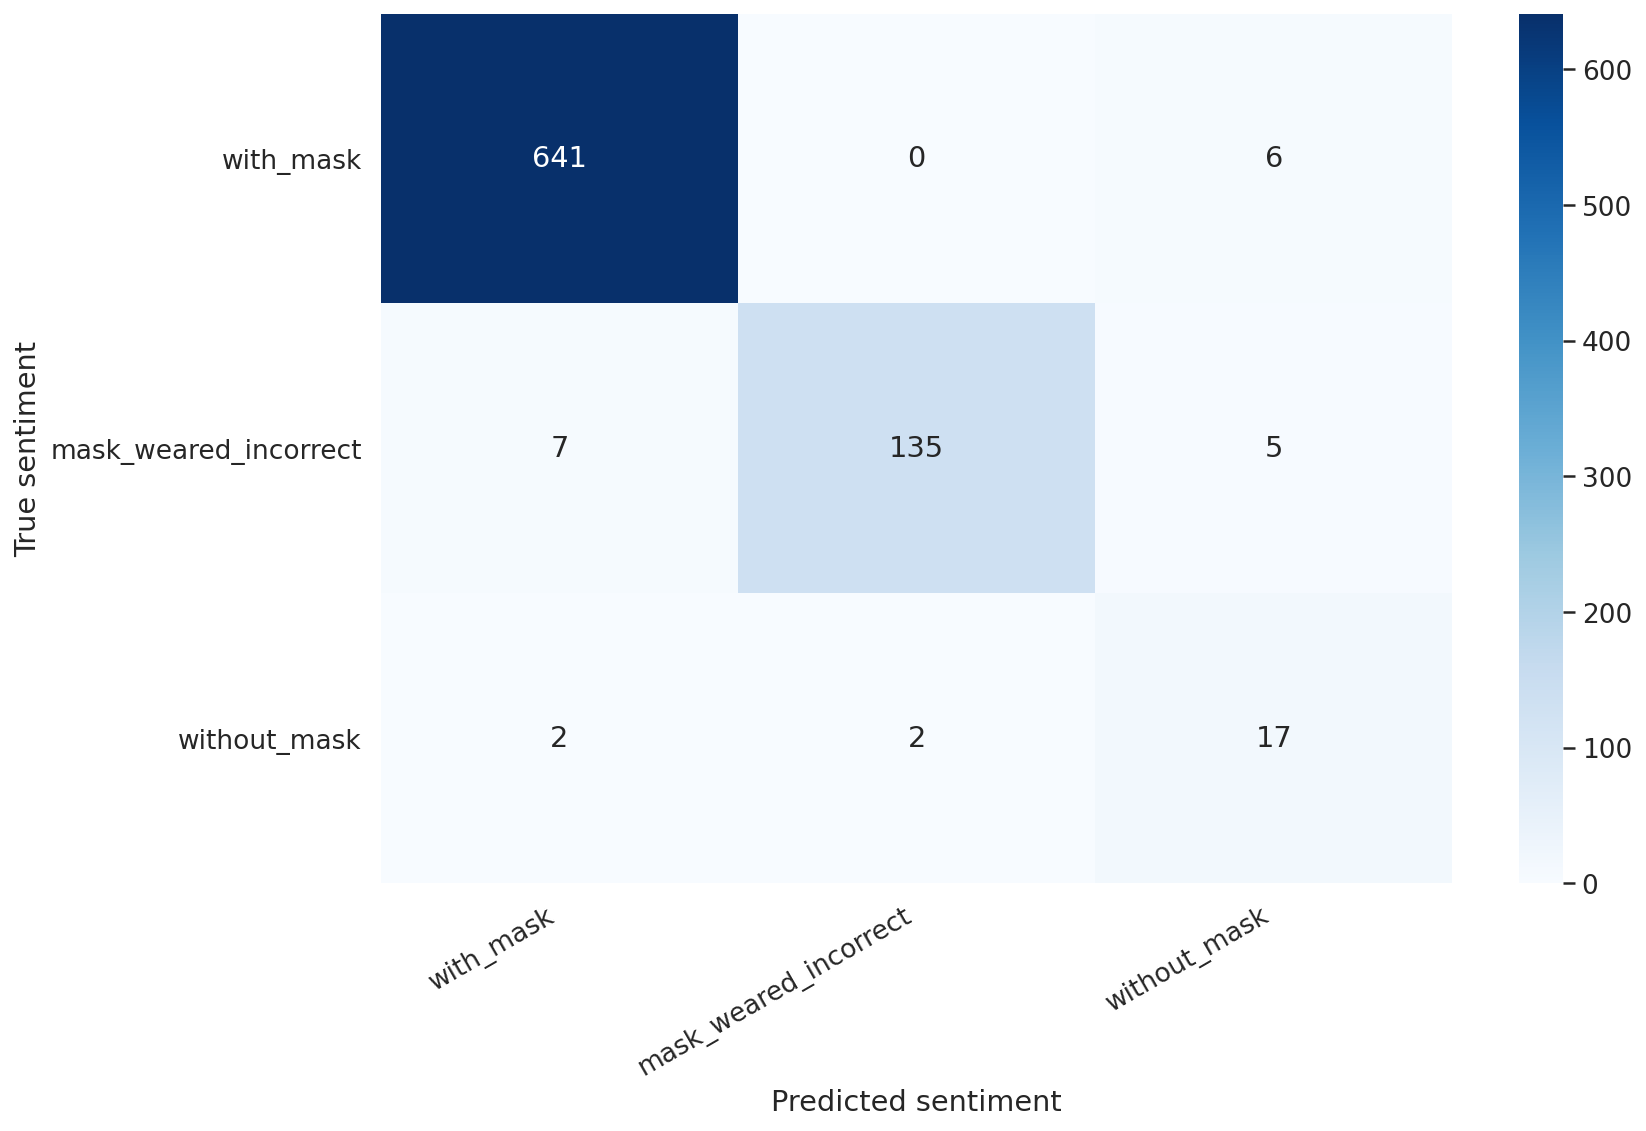

In [23]:
from sklearn.metrics import confusion_matrix, classification_report,precision_score,accuracy_score,f1_score
torch.save(resnet,open("resnet_model_face_mask","wb"))
class_names = ['with_mask', 'mask_weared_incorrect', 'without_mask']
print(classification_report(predictions, real_values, target_names=class_names))

def show_confusion_matrix(confusion_matrix):
  hmap = sns.heatmap(confusion_matrix, annot=True, fmt="d", cmap="Blues")
  hmap.yaxis.set_ticklabels(hmap.yaxis.get_ticklabels(), rotation=0, ha='right')
  hmap.xaxis.set_ticklabels(hmap.xaxis.get_ticklabels(), rotation=30, ha='right')
  plt.ylabel('True sentiment')
  plt.xlabel('Predicted sentiment');

cm = confusion_matrix(predictions, real_values)
df_cm = pd.DataFrame(cm, index=class_names, columns=class_names)
show_confusion_matrix(df_cm)

As we can see, the models performs almost perfectly on people wearing masks, a little less good on people wearing masks incorrectly but it is still excellent. However it is a considerably less performant on people without mask which is problematic, as it is especially those people that we dont want to miss !



Save and reload the pretrained resnet model that will be inserted in a head model, in this case the MTCNN head.

MTCNN is a face detection neural networks of pyramidal architecture  making Non-Max-Suppression and bounding box regression at each stage of the pyramid.

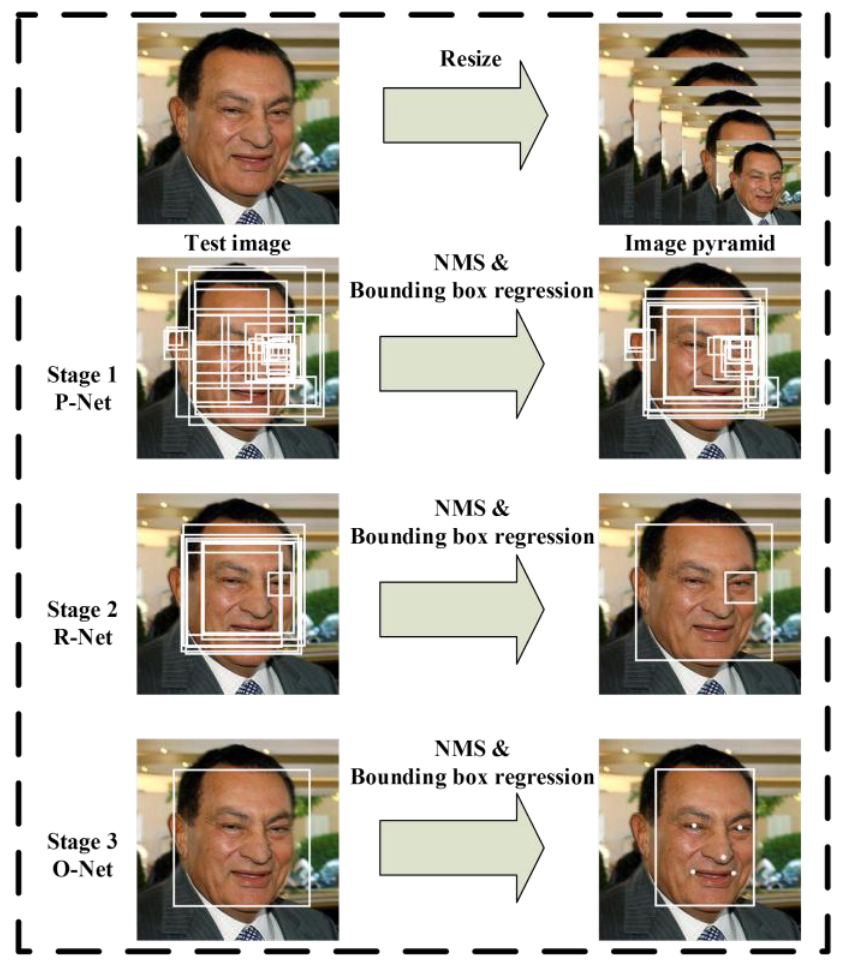

# III. Results visualization

The process for detection the classes and regressing the bounding boxes is the following : first MTCNN detect faces on images and regresses the bounding boxes, the pretrained resnet model makes prediction on the crop obtained with MTCNN in order to check whether or not the mask is wore, badly wore or not wore. 
Then the results are plotted accordingly with a distinctive color depending on the detected class.

In [27]:
torch.save(resnet,open("resnet_model_face_mask","wb")) # saving the trained model.

In [28]:
device = torch.device("cuda")
model=torch.load(open("resnet_model_face_mask","rb"),map_location=device) #loading the model

In [29]:
!pip install mtcnn #installing library for predicting faces

     |████████████████████████████████| 2.3MB 15.2MB/s 


In [30]:
# https://towardsdatascience.com/face-detection-using-mtcnn-a-guide-for-face-extraction-with-a-focus-on-speed-c6d59f82d49

from mtcnn import MTCNN
detect = MTCNN()

Create custom function to read, resize crop and convert to pytorch tensors the datas, display them with bounding boxes.


In [31]:
def trans(bndbox,newimage):

    a,b,c,d = bndbox["box"]
    image_crop = transforms.functional.crop(newimage, b,a,d-b,c-a)
    my_transform = transforms.Compose([transforms.Resize((226,226)),
                                     transforms.RandomCrop((224,224)),
                                     transforms.ToTensor()])(image_crop)
                                     
    return my_transform

This function draw the rectangles from the bouding boxes coordinates and put the text label for each detection


In [117]:
def tag_plot(bndbox,filepath,i,predicted):

  configut=["with_mask","without_mask","mask_weared_incorrect"]

  x = plt.imread(filepath)
  fig = plt.figure(figsize=(25,25))
  ax = fig.add_subplot(20/2,2,i+1,xticks=[],yticks=[])
  ax.axis("off")
  fig.set_size_inches(20,20)

  for i,j in zip(bndbox,predicted):
      a,b,c,d=i["box"]
      patch = patches.Rectangle((a,b),c,d,linewidth=1, edgecolor='r',facecolor="none",)
      ax.imshow(x)
      ax.text(a, b, configut[predicted[0]], size=10,
              style='italic',verticalalignment="bottom", horizontalalignment="left",color="blue")
      ax.add_patch(patch)
      plt.show()

The testing() function is used to detect the faces with the MTCNN model, then it crops the images with the trans() function with return an object which is then passed as an input to the previously instantiated model object which returns the name of the class with the most confidence value. 

Then the tag_plot() function is used with as first argument the bounding boxes obtained from MTCNN face detectors, the filename of the original images which will be read and on which the coordinates of the bouding boxes passed as the first argument as well as the class name passed as the third argument will be plotted.

In [91]:
model = model.eval()

def testing(filepath, i):

    configut=["with_mask","without_mask","mask_weared_incorrect"]

    img = cv2.cvtColor(cv2.imread(filepath), cv2.COLOR_BGR2RGB)
    newimage=Image.open(filepath).convert("RGB")
    bndbox=detect.detect_faces(img)

    if len(bndbox)==1:

        image_pred = trans(bndbox[0],newimage).unsqueeze(0)
        _, pred=torch.max(model(image_pred.to(device)),1)
        tag_plot(bndbox,filepath,i,predicted=pred)
    
    else:
        predicted=[]
        for j in bndbox:
            image_pred=trans(j,newimage).unsqueeze(0)
            _, pred=torch.max(model(image_pred.to(device)),1)
            predicted.append(pred)
        tag_plot(bndbox,filepath,i,predicted)

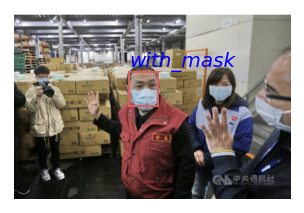

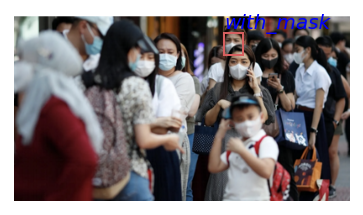

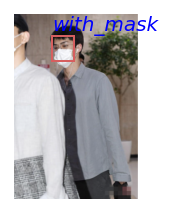

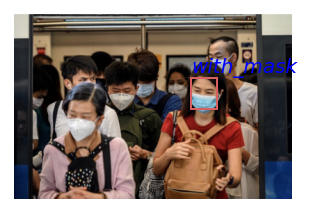

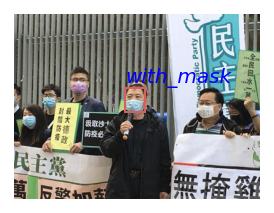

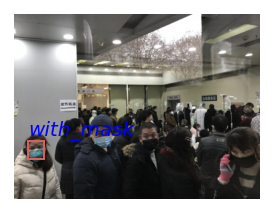

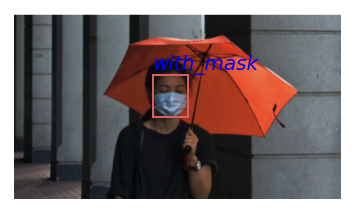

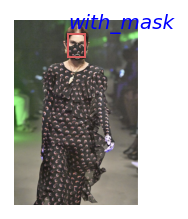

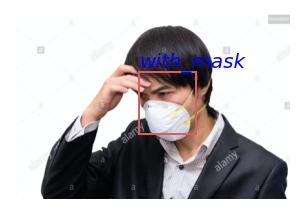

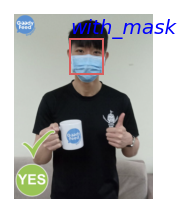

In [119]:
for i in np.arange(10):
 testing(path_im+imagenames[130+i], i) # if you have images you can test them using this function..

As we can see, and thus confirming our initial hypothesis, the models clearly miss a lot of the masked people in crowded environement. This can be due to annotation mistakes, inbalanced of the models where too much images are single person, meaning that the model may associate wearing a mask with being alone on the picture, or it could be the environment or lack of datas or a lot of other factors ....

That's why we think that a good model, ready for industrial uses should be traine don a massive dataset like the one recently built by French Researchers available at https://github.com/cabani/MaskedFace-Net [2]

[2] Adnane Cabani, Karim Hammoudi, Halim Benhabiles, and Mahmoud Melkemi, "MaskedFace-Net - A dataset of correctly/incorrectly masked face images in the context of COVID-19", Smart Health, ISSN 2352-6483, Elsevier, 2020